# 0. Imports

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score,root_mean_squared_error,mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

# Functions

In [64]:
def calculate_metrics(nome_algoritmo, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)  
    r2   = r2_score(y_true, y_pred)

    df = pd.DataFrame({
        "Algorithm": [nome_algoritmo],
        "MAE": [round(mae,4)],
        "RMSE": [round(rmse,4)],
        "R2": [round(r2,4)]
    })
    return df

# 1. Data load

In [13]:
df = pd.read_csv('../datasets/dados_passagens.csv')

In [14]:
df.shape

(206774, 13)

In [15]:
df.head()

,Unnamed: 0,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,days_left
0,0,11-02-2022,SpiceJet,SG,8709,18:55,Delhi,02h 10m,non-stop,21:05,Mumbai,"5,953",1
1,1,11-02-2022,SpiceJet,SG,8157,06:20,Delhi,02h 20m,non-stop,08:40,Mumbai,"5,953",1
2,2,11-02-2022,AirAsia,I5,764,04:25,Delhi,02h 10m,non-stop,06:35,Mumbai,"5,956",1
3,3,11-02-2022,Vistara,UK,995,10:20,Delhi,02h 15m,non-stop,12:35,Mumbai,"5,955",1
4,4,11-02-2022,Vistara,UK,963,08:50,Delhi,02h 20m,non-stop,11:10,Mumbai,"5,955",1


# 2. Data Description

In [16]:
df2 = df.copy()

## 2.1 Data Shape

In [17]:
df2.shape

(206774, 13)

## 2.2 Data Types

In [18]:
df2.dtypes

Unnamed: 0     int64
date          object
airline       object
ch_code       object
num_code       int64
dep_time      object
from          object
time_taken    object
stop          object
arr_time      object
to            object
price         object
days_left      int64
dtype: object

In [19]:
df2['date'] = pd.to_datetime(df2['date'],dayfirst=True)
df2['num_code'] = df2['num_code'].astype('object')
df2["price"] = (
    df2["price"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .str.replace(" ", "", regex=False)
    .replace("nan", None)
    .astype(float)
)
df2["dep_time"] = pd.to_datetime(df2["dep_time"], format="%H:%M", errors="coerce")
df2["arr_time"] = pd.to_datetime(df2["arr_time"], format="%H:%M", errors="coerce")
df2["duration_min"] = (
    pd.to_timedelta(df["time_taken"].str.replace(" ", "", regex=False), errors="coerce")
    .dt.total_seconds() / 60
).astype("Int64")

df2_1 = df2.drop(columns=['Unnamed: 0','time_taken'])

In [20]:
df2_1.dtypes

date            datetime64[ns]
airline                 object
ch_code                 object
num_code                object
dep_time        datetime64[ns]
from                    object
stop                    object
arr_time        datetime64[ns]
to                      object
price                  float64
days_left                int64
duration_min             Int64
dtype: object

## 2.3 Checking NA

In [21]:
df2_1.isnull().sum()

date            0
airline         0
ch_code         0
num_code        0
dep_time        0
from            0
stop            0
arr_time        0
to              0
price           0
days_left       0
duration_min    4
dtype: int64

## 2.4 Adjust stop column extra spaces

In [22]:
df2_1["stop"] = (
    df2_1["stop"]
      .astype(str)
      .str.replace(r"\s+", " ", regex=True)  
      .str.strip()
)

print(df2_1["stop"].value_counts(dropna=False))

stop
1-stop                       162114
non-stop                      27942
2+-stop                       12205
1-stop Via IXU                 1063
1-stop Via IDR                  588
1-stop Via Patna                432
1-stop Via Indore               381
1-stop Via MYQ                  321
1-stop Via KLH                  284
1-stop Via Bhubaneswar          226
1-stop Via JGB                  193
1-stop Via JRG                  175
1-stop Via Ranchi               114
1-stop Via PAT                   97
1-stop Via Delhi                 94
1-stop Via STV                   76
1-stop Via Hyderabad             72
1-stop Via Raipur                59
1-stop Via Mysore                45
1-stop Via Mangalore             39
1-stop Via Chennai               35
1-stop Via IXE                   34
1-stop Via Mumbai                31
1-stop Via Guwahati              26
1-stop Via Nagpur                25
1-stop Via GOP                   16
1-stop Via Kolkata               14
1-stop Via Surat       

# 3 Feature Engineering

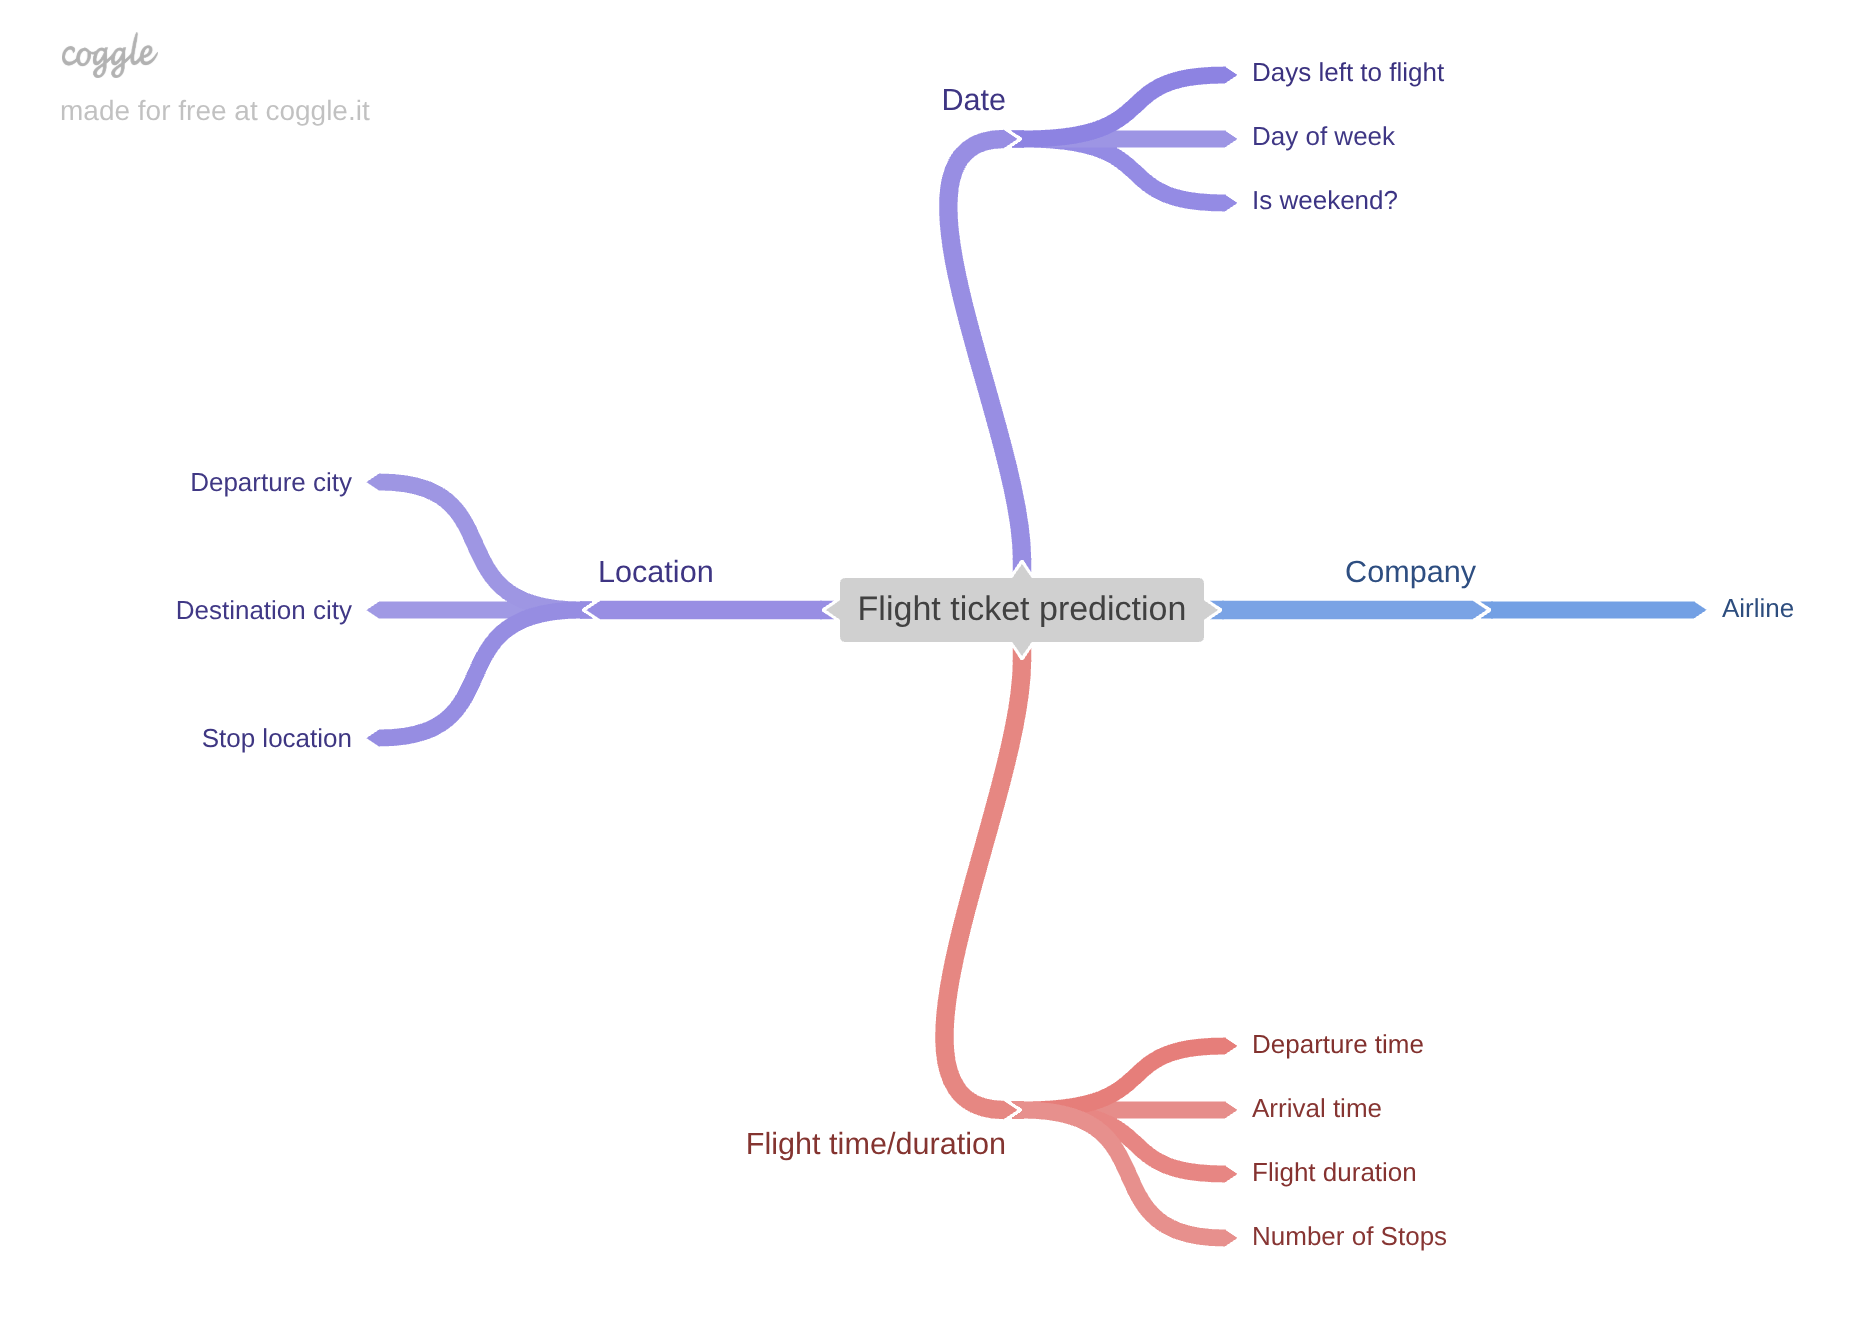

In [23]:
Image('../Images/Hypothesis_Mindmap.png')

## 3.1 Adjust departure time and arrival time

In [24]:
bins   = [0, 4, 8, 12, 17, 21, 24]
labels = ["Late Night", "Early Morning", "Morning", "Afternoon", "Evening", "Night"]
order  = labels  

h_dep = df2_1["dep_time"].dt.hour
h_arr = df2_1["arr_time"].dt.hour

df2_1["dep_period"] = pd.cut(h_dep, bins=bins, labels=labels, right=False, include_lowest=True)
df2_1["arr_period"] = pd.cut(h_arr, bins=bins, labels=labels, right=False, include_lowest=True)

## 3.2 Data based Extra Columns

In [25]:
df2_1["is_weekend"] = df2_1["date"].dt.dayofweek.isin([4, 5, 6]).astype("category")
df2_1["day_of_week_num"] = df2_1["date"].dt.dayofweek.astype("category")
df2_2 = df2_1.drop(columns=['dep_time','arr_time'])
df2_2.head(10)

,date,airline,ch_code,num_code,from,stop,to,price,days_left,duration_min,dep_period,arr_period,is_weekend,day_of_week_num
0,2022-02-11,SpiceJet,SG,8709,Delhi,non-stop,Mumbai,5953.0,1,130,Evening,Night,True,4
1,2022-02-11,SpiceJet,SG,8157,Delhi,non-stop,Mumbai,5953.0,1,140,Early Morning,Morning,True,4
2,2022-02-11,AirAsia,I5,764,Delhi,non-stop,Mumbai,5956.0,1,130,Early Morning,Early Morning,True,4
3,2022-02-11,Vistara,UK,995,Delhi,non-stop,Mumbai,5955.0,1,135,Morning,Afternoon,True,4
4,2022-02-11,Vistara,UK,963,Delhi,non-stop,Mumbai,5955.0,1,140,Morning,Morning,True,4
5,2022-02-11,Vistara,UK,945,Delhi,non-stop,Mumbai,5955.0,1,140,Morning,Afternoon,True,4
6,2022-02-11,Vistara,UK,927,Delhi,non-stop,Mumbai,6060.0,1,125,Morning,Morning,True,4
7,2022-02-11,Vistara,UK,951,Delhi,non-stop,Mumbai,6060.0,1,130,Afternoon,Afternoon,True,4
8,2022-02-11,GO FIRST,G8,334,Delhi,non-stop,Mumbai,5954.0,1,130,Morning,Morning,True,4
9,2022-02-11,GO FIRST,G8,336,Delhi,non-stop,Mumbai,5954.0,1,135,Afternoon,Afternoon,True,4


## 3.3 Stop Colums

In [26]:
s = df2_2['stop'].fillna('')
qty_raw = s.str.extract(r'(?i)^\s*((?:non|[0-9]+(?:\+)?)-stop)\b')[0]
df2_2['qty_stop'] = (
    qty_raw
    .str.replace(r'(?i)non-stop', '0', regex=True)
    .str.replace(r'(?i)(\d+)\+-stop', lambda m: f"{m.group(1)}+", regex=True)  
    .str.replace(r'(?i)(\d+)-stop', r'\1', regex=True)                         
    .fillna('n/a')
)

df2_2['stop_place'] = (
    df2_2['stop']
    .str.extract(r'(?i)\bvia\s+(.+)$')[0]  
    .str.strip()
    .replace(r'^\s*$', pd.NA, regex=True)  
    .astype('category')                    
)

df2_3 = df2_2.drop(columns=['stop','num_code','ch_code','date'])


In [27]:
distinct_counts = df2_3.nunique()
df2_3.dtypes

airline              object
from                 object
to                   object
price               float64
days_left             int64
duration_min          Int64
dep_period         category
arr_period         category
is_weekend         category
day_of_week_num    category
qty_stop             object
stop_place         category
dtype: object

## 3.4 Hypothesis List

### 3.4.1 - Location Hypothesis

- Departure City impacts the flight price
- Destination City impacts the flight price
- Stop location place impacts the flight price

### 3.4.2 Date flight Hypothesis

- Flights on weekends are more expensive
- Day of week impacts flight price

### 3.4.3 Flight time and duration Hypothesis

- The number of stops decrease the flight time
- Late departure flights are more expensive
- Late arrival flights are more expesive
- Long flights tends to be more expensive

### 3.4.4

- Some flight companies are cheaper than others

# 4 Exploratory Analysis

In [28]:
df4 = df2_3.copy()
df4.dtypes

airline              object
from                 object
to                   object
price               float64
days_left             int64
duration_min          Int64
dep_period         category
arr_period         category
is_weekend         category
day_of_week_num    category
qty_stop             object
stop_place         category
dtype: object

In [29]:
num_column = df4.select_dtypes(include=['number','int64']).columns
cat_column = df4.select_dtypes(include=['object','category']).columns

print(f'List numerical columns: \n{num_column}')
print(f'\nList categorical columns: \n{cat_column}')

List numerical columns: 
Index(['price', 'days_left', 'duration_min'], dtype='object')

List categorical columns: 
Index(['airline', 'from', 'to', 'dep_period', 'arr_period', 'is_weekend',
       'day_of_week_num', 'qty_stop', 'stop_place'],
      dtype='object')


## 4.1 Descriptive Analysis

In [30]:
df4[["price", "days_left", "duration_min"]].describe()

,price,days_left,duration_min
count,206774.000000,206774.000000,206770.0
mean,6571.190701,26.110909,692.753809
std,3743.442838,13.537600,434.529088
min,1105.000000,1.000000,50.0
25%,4173.000000,15.000000,375.0
50%,5772.000000,26.000000,610.0
75%,7746.000000,38.000000,915.0
max,42349.000000,49.000000,2990.0


## 4.2 Univariate Analysis

### 4.2.1 - Categorical Univariate Analysis

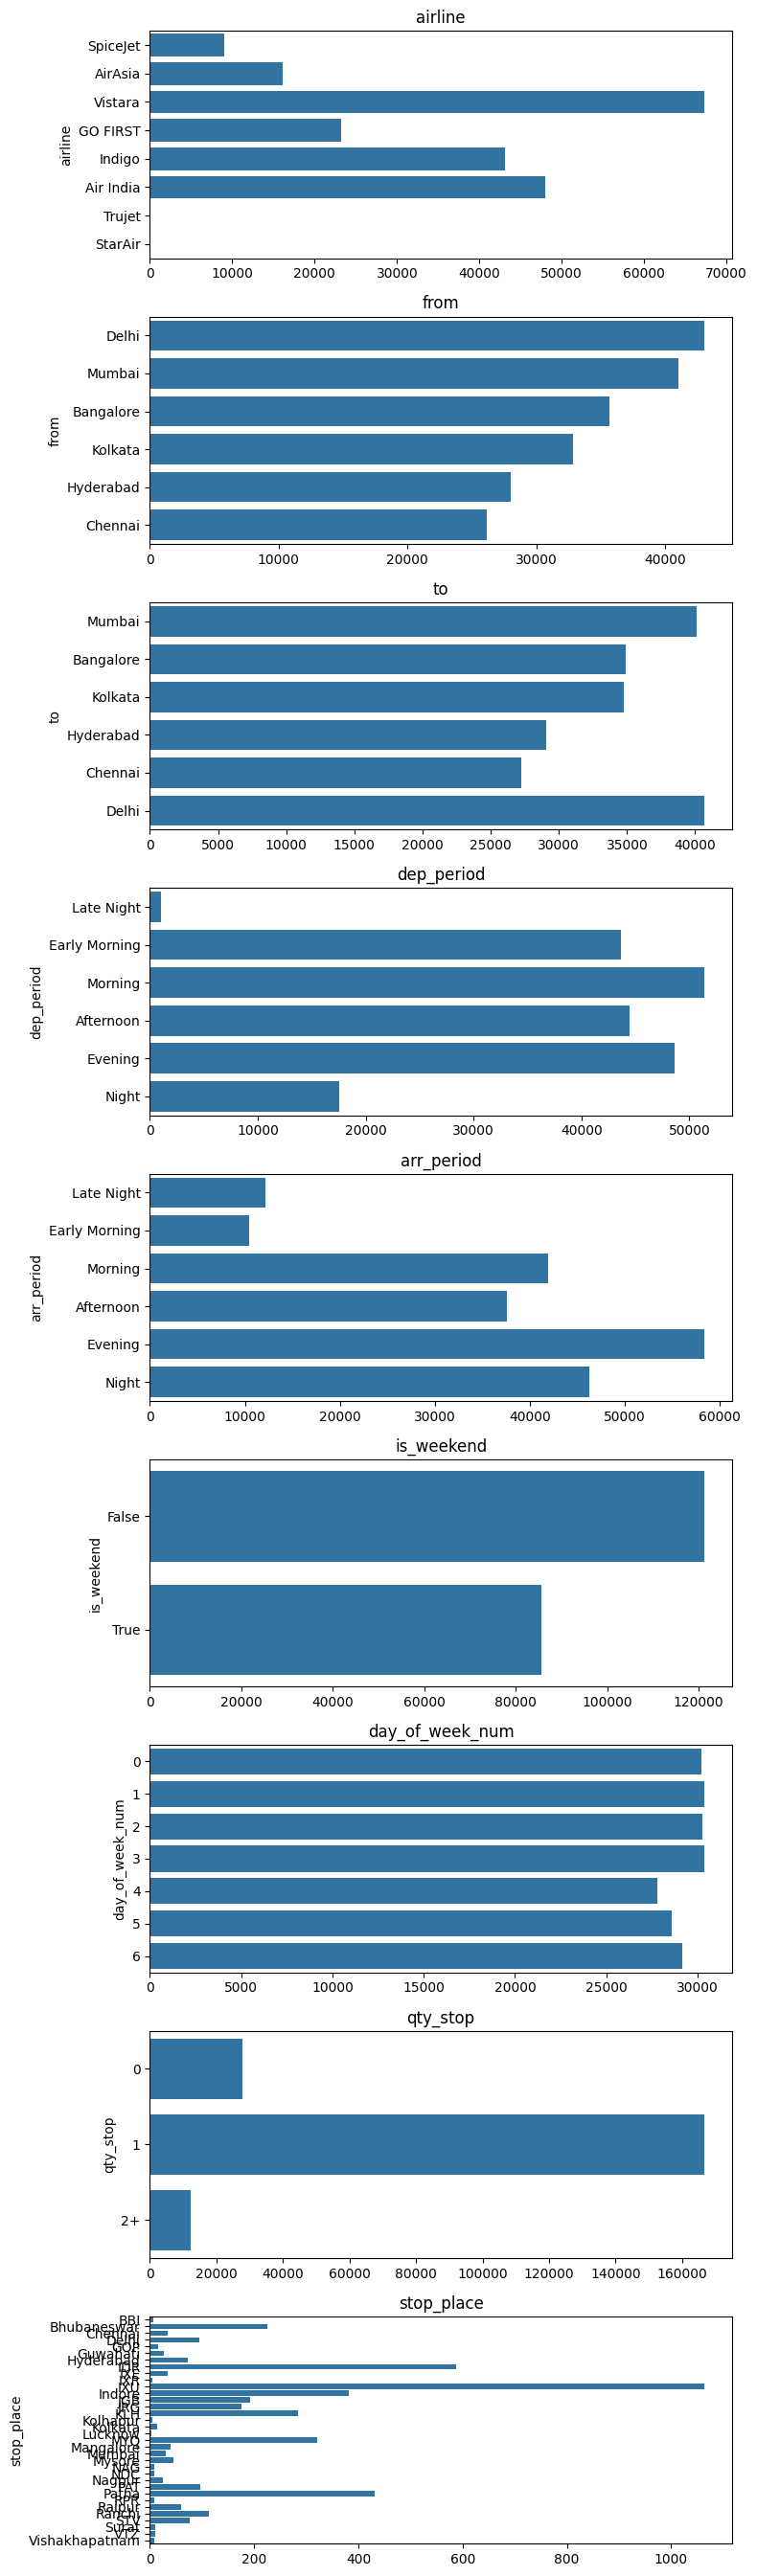

In [32]:
fig, ax = plt.subplots(nrows=len(cat_column), figsize=(8, len(cat_column) * 3))
for i in range(len(cat_column)):
    sns.countplot(df4[cat_column[i]], ax=ax[i])
    ax[i].set_title(cat_column[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

### 4.2.2 Numeric Univariate Analysis


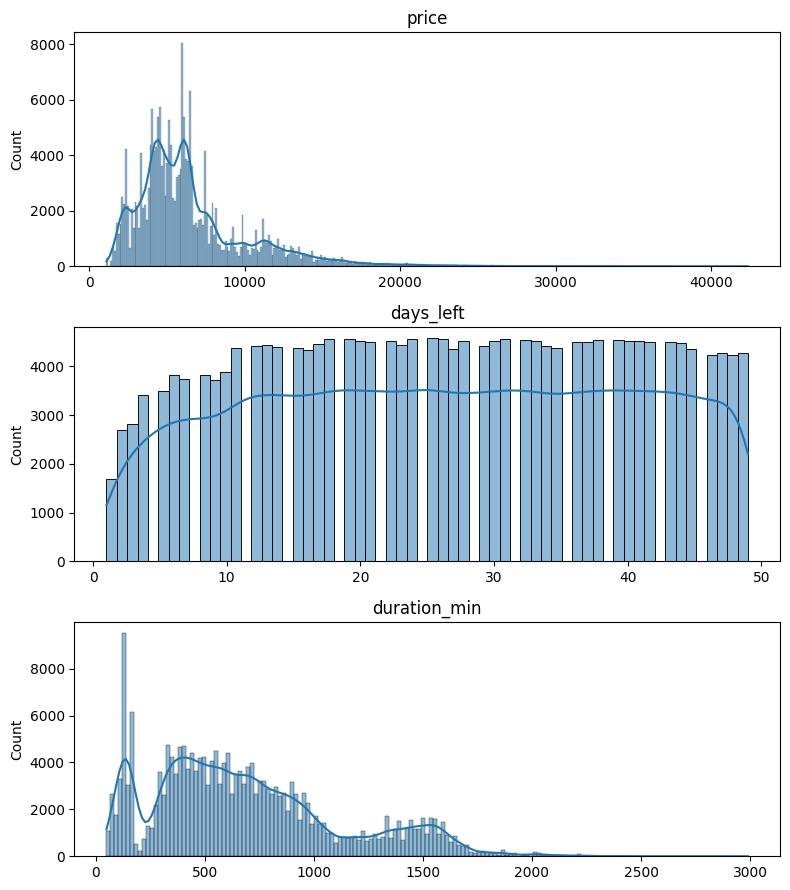

In [33]:
fig, ax = plt.subplots(nrows=len(num_column), figsize=(8, len(num_column) * 3))

if len(num_column) == 1:
    ax = [ax]

for i in range(len(num_column)):
    sns.histplot(df4[num_column[i]], ax=ax[i],kde=True)
    ax[i].set_title(num_column[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()


## 4.2 Bivariate Analysis

### 4.2.1 Bivariate Numeric Analysis

C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\329305649.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = df4[num_column[i]], ax=ax[i], palette='rocket')
C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\329305649.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = df4[num_column[i]], ax=ax[i], palette='rocket')
C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\329305649.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = df4[num_column[i]], ax=ax[i], palette='rocket')


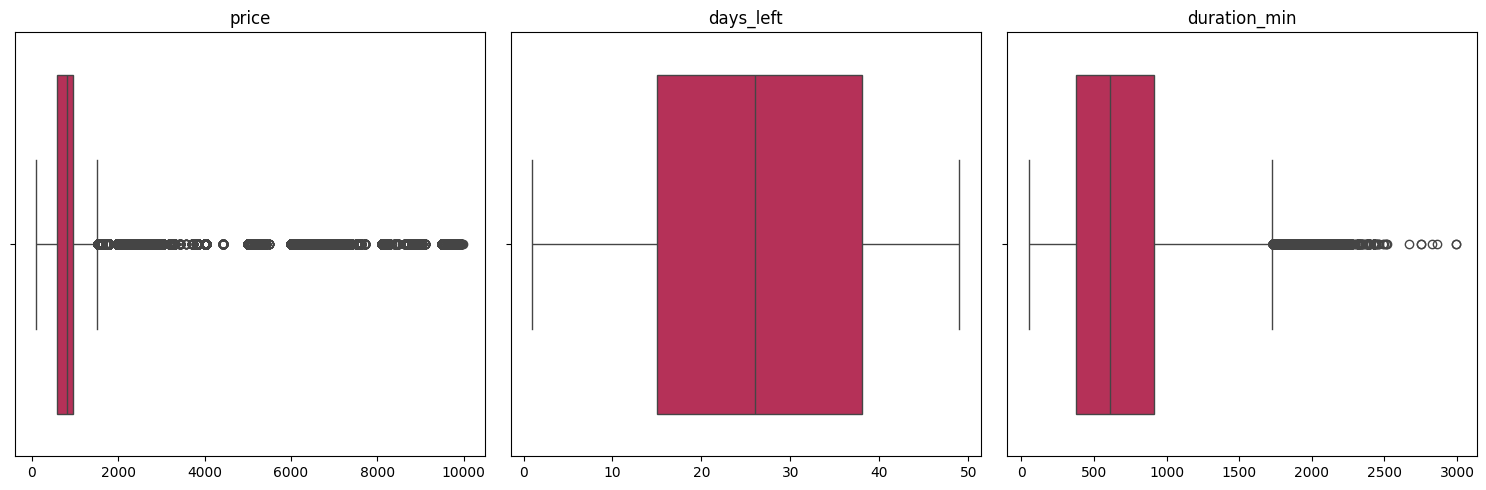

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(num_column), figsize=(15, 5))

for i in range(0, len(num_column)):
    sns.boxplot(x = df4[num_column[i]], ax=ax[i], palette='rocket')
    ax[i].set_title(num_column[i])
    ax[i].set_xlabel('')

plt.tight_layout()
plt.show()

### 4.2.2 Bivariate Categorical Analysis

C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\2583422518.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_categories,
C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\2583422518.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_categories,
C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\2583422518.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_categories,
C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\2583422518.py:8: FutureWarning: The default of observed=False is deprecated and wil

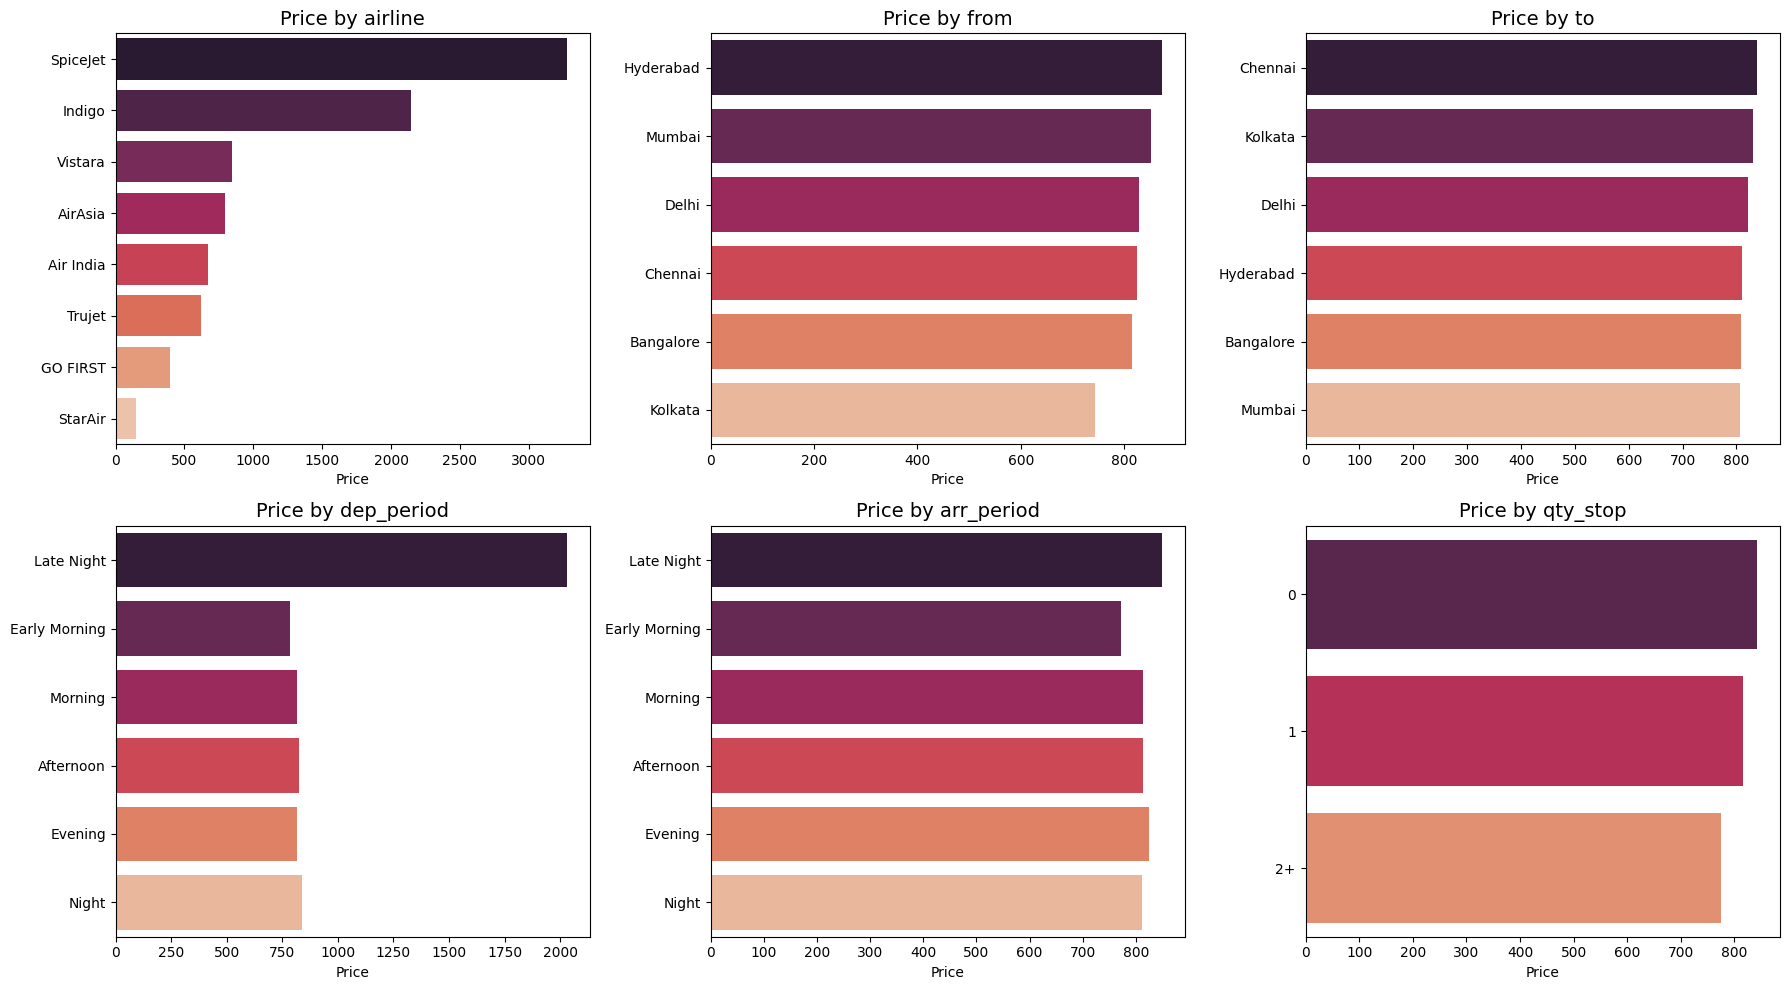

In [ ]:
list_col = ['airline', 'from','to','dep_period', 'arr_period', 'qty_stop']
# create subplots
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
ax = ax.flatten()

# loop through each category in the barchart_list
for i, bar in enumerate(list_col):
    flight_fare = df4.groupby(bar)['price'].median().reset_index()
    sorted_categories = flight_fare.sort_values(by = 'price', ascending=False)

    # create a bar plot for each category
    sns.barplot(data=sorted_categories,
                y = bar,
                x ='price',
                palette = 'rocket',
                ax = ax[i])

    # set the title and labels for each subplot
    ax[i].set_title(f'Price by {bar}', fontsize=14)
    ax[i].set_xlabel('Price')
    ax[i].set_ylabel('')

plt.tight_layout()
plt.show()

C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\2053196210.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_airline,
C:\Users\rafae\AppData\Local\Temp\ipykernel_27784\2053196210.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df4,


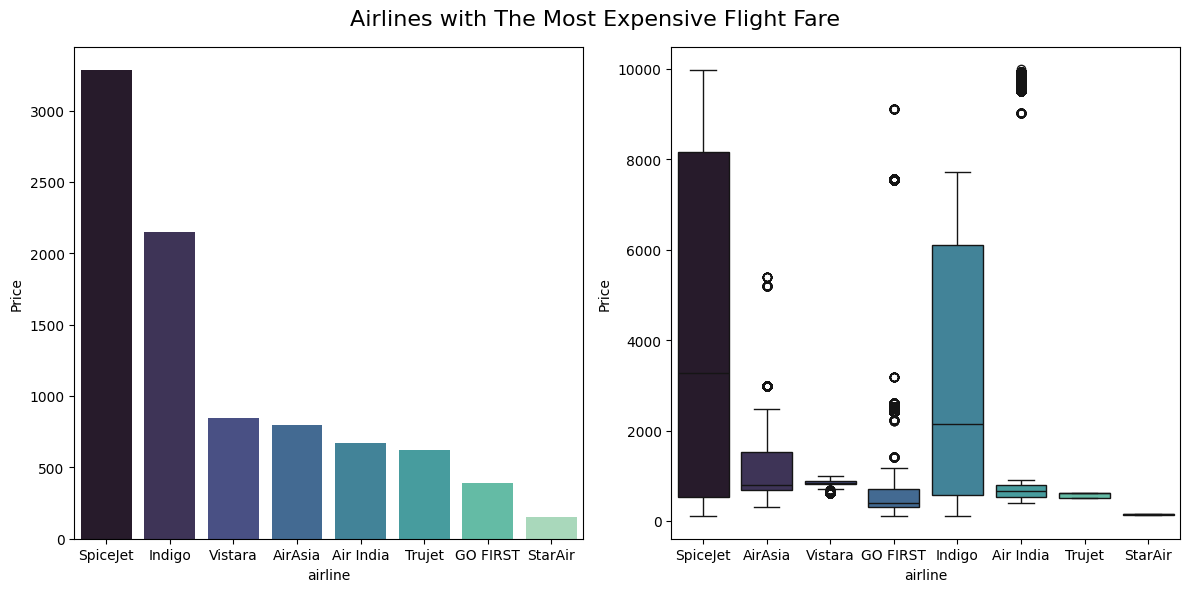

In [ ]:
# calculate and sort the airlines based on median price
median_price_airline = df4.groupby('airline')['price'].median().reset_index()
sorted_airline = median_price_airline.sort_values(by='price', ascending=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
plt.suptitle('Airlines with The Most Expensive Flight Fare',fontsize=16)

sns.barplot(data=sorted_airline,
            x='airline',
            y='price',
            palette = 'mako',
            ax = ax[0])
ax[0].set_xlabel('airline')
ax[0].set_ylabel('Price')

sns.boxplot(data=df4,
            x='airline',
            y='price',
            palette = 'mako',
            ax = ax[1])
ax[1].set_xlabel('airline')
ax[1].set_ylabel('Price')

plt.tight_layout()
plt.show()

### 4.2.3 Multivariable Analysis

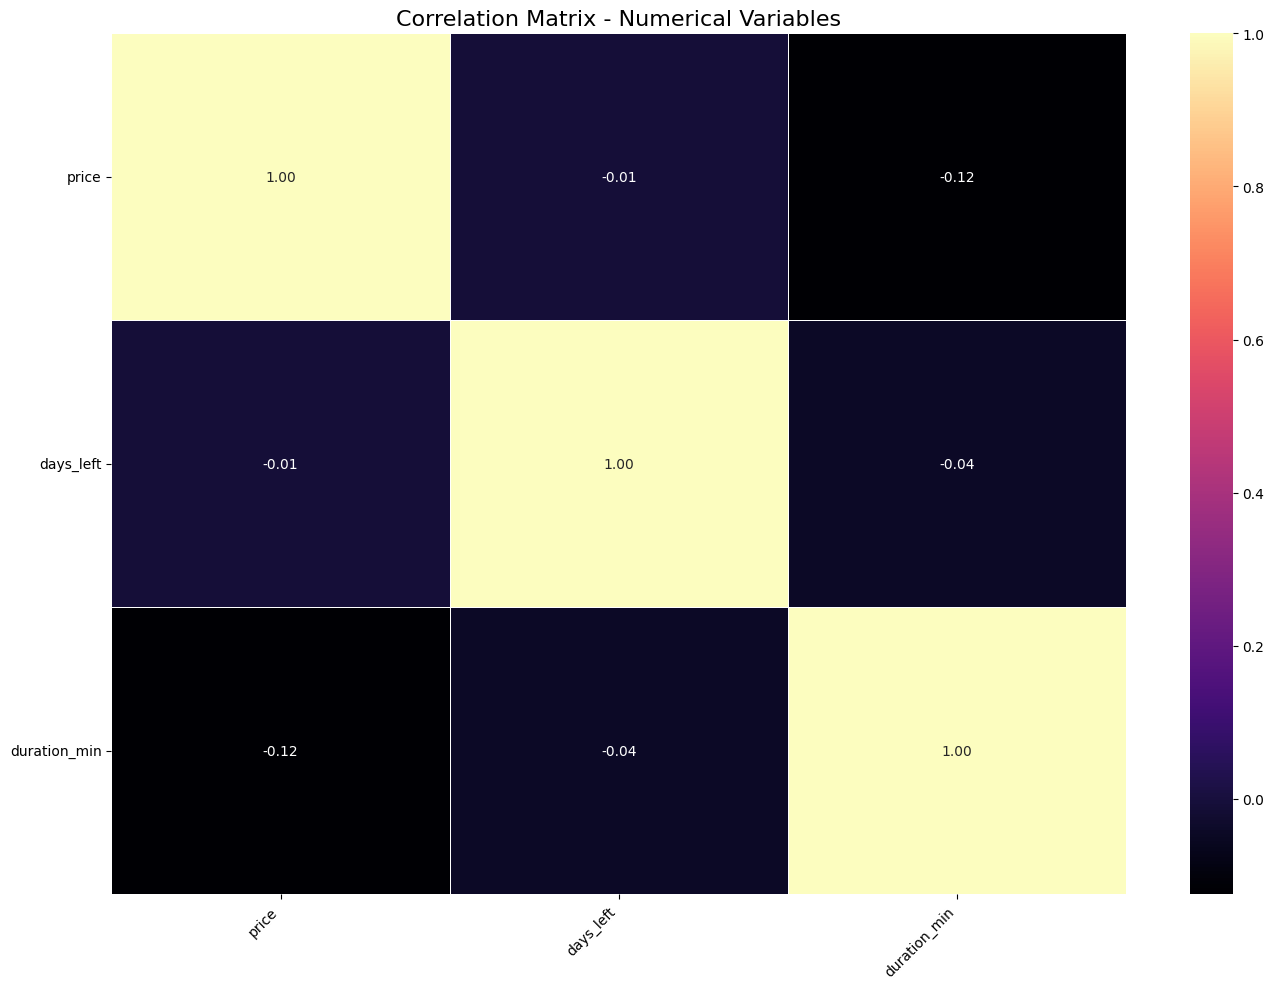

In [ ]:
num_variables = df4.select_dtypes(include=['int64','float64'])
correlation = num_variables.corr(method='pearson')

plt.figure(figsize=(14, 10))

sns.heatmap(correlation, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix - Numerical Variables', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Preprocessing

In [34]:
df5 = df4.copy()

y = df5["price"]
X = df5.drop(columns=["price"])

## 5.1 Train-Test Split

In [35]:
df5.dtypes

airline              object
from                 object
to                   object
price               float64
days_left             int64
duration_min          Int64
dep_period         category
arr_period         category
is_weekend         category
day_of_week_num    category
qty_stop             object
stop_place         category
dtype: object

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

for col in cat_cols:
    top = X_train[col].value_counts().nlargest(20).index
    X_train[col] = np.where(X_train[col].isin(top), X_train[col], "Other")
    X_test[col]  = np.where(X_test[col].isin(top), X_test[col], "Other")

## 5.2 Scaling

In [38]:
scaler = RobustScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num  = scaler.transform(X_test[num_cols])

## 5.3 Encoding


In [39]:
for col in cat_cols:
    top = X_train[col].value_counts().nlargest(20).index
    X_train[col] = np.where(X_train[col].isin(top), X_train[col], "Other")
    X_test[col]  = np.where(X_test[col].isin(top), X_test[col], "Other")

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat  = encoder.transform(X_test[cat_cols])

## 5.4 Final datasets

In [40]:
num_feature_names = num_cols
cat_feature_names = encoder.get_feature_names_out(cat_cols)

X_train_num_df = pd.DataFrame(X_train_num, columns=num_feature_names, index=X_train.index)
X_test_num_df  = pd.DataFrame(X_test_num,  columns=num_feature_names, index=X_test.index)

X_train_cat_df = pd.DataFrame(X_train_cat, columns=cat_feature_names, index=X_train.index)
X_test_cat_df  = pd.DataFrame(X_test_cat,  columns=cat_feature_names, index=X_test.index)

X_train_ready = pd.concat([X_train_num_df, X_train_cat_df], axis=1)
X_test_ready  = pd.concat([X_test_num_df,  X_test_cat_df], axis=1)

print("Final train dataset:", X_train_ready.shape)
print("Final test dataset:", X_test_ready.shape)

Final train dataset: (165419, 66)
Final test dataset: (41355, 66)


In [41]:
distinct_counts = X_train_ready.nunique()

X_train_ready.columns.to_list()


['days_left',
 'duration_min',
 'airline_Air India',
 'airline_AirAsia',
 'airline_GO FIRST',
 'airline_Indigo',
 'airline_SpiceJet',
 'airline_StarAir',
 'airline_Trujet',
 'airline_Vistara',
 'from_Bangalore',
 'from_Chennai',
 'from_Delhi',
 'from_Hyderabad',
 'from_Kolkata',
 'from_Mumbai',
 'to_Bangalore',
 'to_Chennai',
 'to_Delhi',
 'to_Hyderabad',
 'to_Kolkata',
 'to_Mumbai',
 'dep_period_Afternoon',
 'dep_period_Early Morning',
 'dep_period_Evening',
 'dep_period_Late Night',
 'dep_period_Morning',
 'dep_period_Night',
 'arr_period_Afternoon',
 'arr_period_Early Morning',
 'arr_period_Evening',
 'arr_period_Late Night',
 'arr_period_Morning',
 'arr_period_Night',
 'is_weekend_False',
 'is_weekend_True',
 'day_of_week_num_0',
 'day_of_week_num_1',
 'day_of_week_num_2',
 'day_of_week_num_3',
 'day_of_week_num_4',
 'day_of_week_num_5',
 'day_of_week_num_6',
 'qty_stop_0',
 'qty_stop_1',
 'qty_stop_2+',
 'stop_place_Bhubaneswar',
 'stop_place_Chennai',
 'stop_place_Delhi',
 'stop_

# 6. Feature importance

In [43]:
model = RandomForestClassifier()

X_sample = X_train_ready.sample(n=1000, random_state=42)
y_sample = y_train.loc[X_sample.index]

model.fit(X_sample, y_sample)
importances = model.feature_importances_

c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.ven\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y, input_name="y")
c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.ven\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y, input_name="y")
c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.ven\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y, input_name="y")
c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.

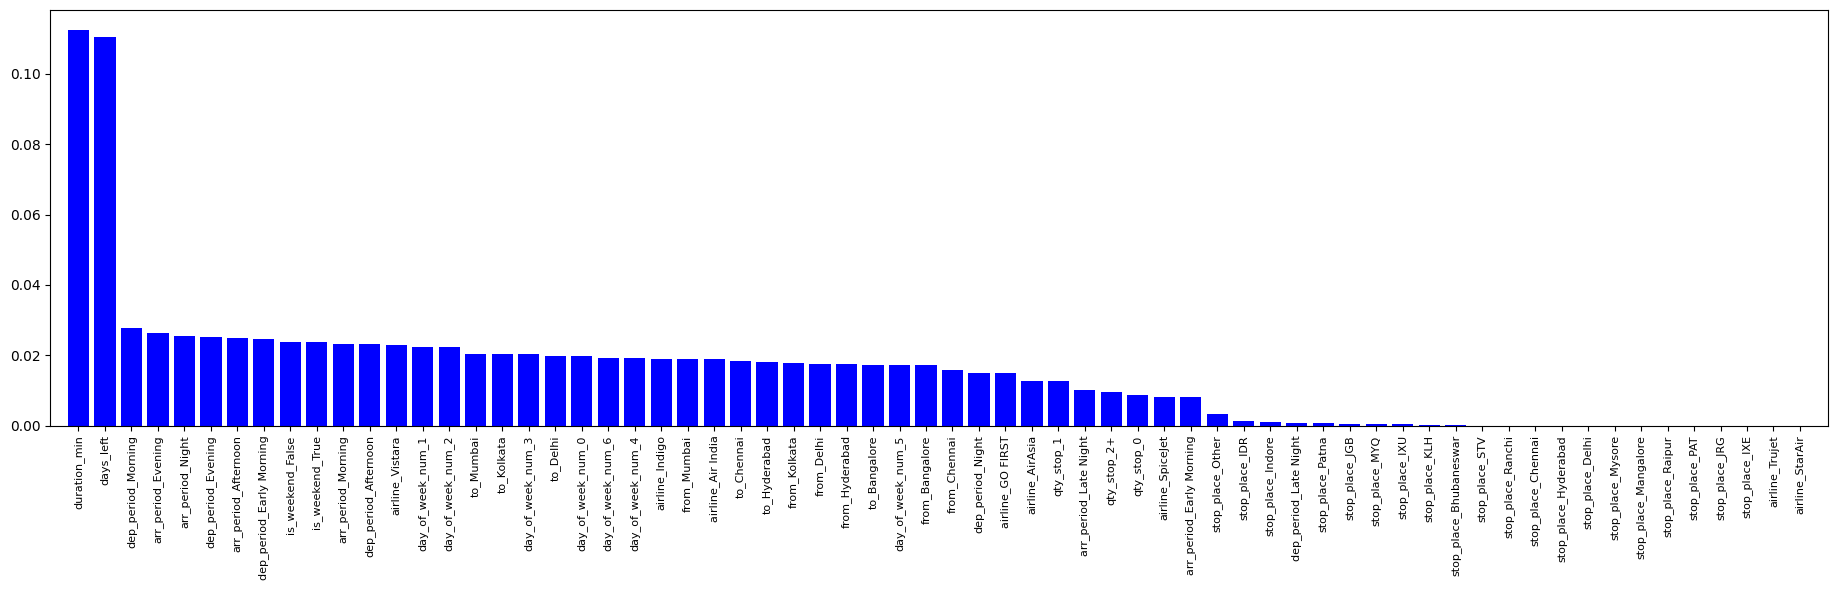

In [47]:
feature_names = X_sample.columns
sorted_index = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_index]
sorted_feature_names = feature_names[sorted_index]


n = len(sorted_importances)
fig, ax = plt.subplots(figsize=(max(10, n*0.28), 6))  # aumenta conforme n
ax.bar(range(n), sorted_importances, color='b', align='center')
ax.set_xticks(range(n))
ax.set_xticklabels(sorted_feature_names, rotation=90, ha='center', fontsize=8)
ax.margins(x=0.01)
fig.tight_layout()   

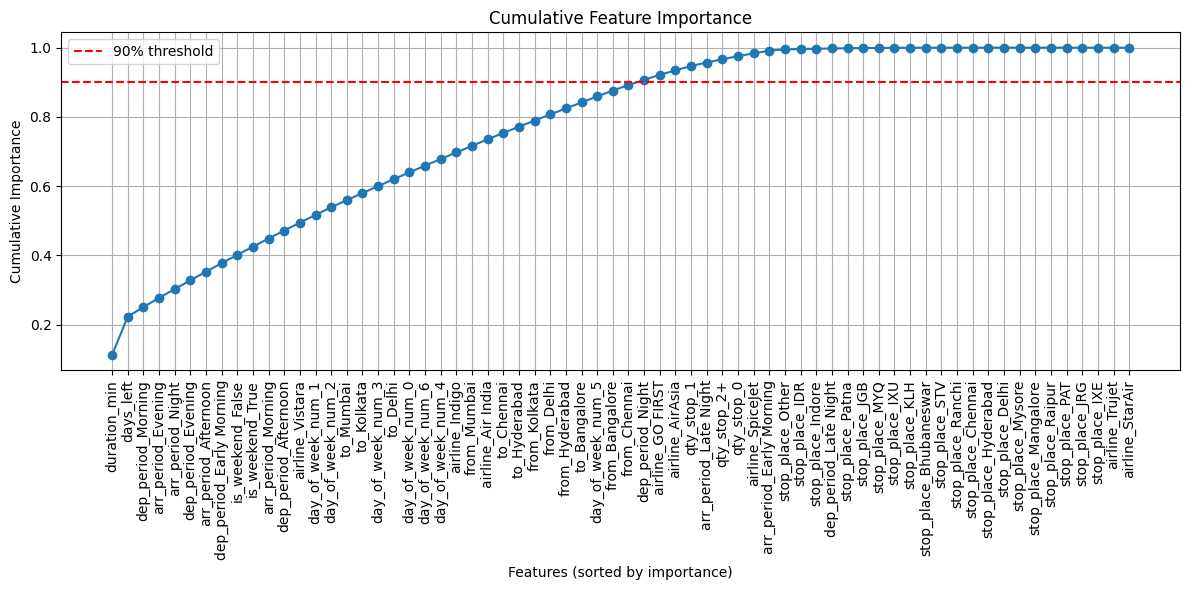

In [48]:
cumulative_importance = np.cumsum(sorted_importances)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_importance)+1), cumulative_importance, marker='o', linestyle='-')
plt.xticks(ticks=range(1, len(sorted_importances)+1), labels=sorted_feature_names, rotation=90)
plt.axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
plt.title('Cumulative Feature Importance')
plt.xlabel('Features (sorted by importance)')
plt.ylabel('Cumulative Importance')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 6.1 Columns Select

In [49]:
model_columns = [
    "duration_min",
    "days_left",
    "dep_period_Morning",
    "arr_period_Evening",
    "arr_period_Night",
    "dep_period_Evening",
    "arr_period_Afternoon",
    "dep_period_Early Morning",
    "is_weekend_False",
    "is_weekend_True",
    "arr_period_Morning",
    "dep_period_Afternoon",
    "airline_Vistara",
    "day_of_week_num_1",
    "day_of_week_num_2",
    "to_Mumbai",
    "to_Kolkata",
    "day_of_week_num_3",
    "to_Delhi",
    "day_of_week_num_0",
    "day_of_week_num_6",
    "day_of_week_num_4",
    "airline_Indigo",
    "from_Mumbai",
    "airline_Air India",
    "to_Chennai",
    "to_Hyderabad",
    "from_Kolkata",
    "from_Delhi",
    "from_Hyderabad",
    "to_Bangalore",
    "day_of_week_num_5",
    "from_Bangalore",
    "from_Chennai",
    "dep_period_Night"
]

# 7. Machine Learning Models

In [65]:
model_columns = [c for c in model_columns if c != "price"]

# 2) Filtrar/alinhar as colunas (ordem + mesmas dummies)
X_train_model = X_train_ready.reindex(columns=model_columns, fill_value=0)
X_test_model  = X_test_ready.reindex(columns=model_columns,  fill_value=0)

# 3) y_train e y_test continuam os mesmos
# y_train, y_test já criados no split anterior

print(X_train_model.shape, X_test_model.shape)

(165419, 35) (41355, 35)


## 7.1 Random Forest

In [66]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_model, y_train)
rf_pred = rf.predict(X_test_model)

metrics_rf = calculate_metrics('Random Forest', y_test, rf_pred)
metrics_rf

,Algorithm,MAE,RMSE,R2
0,Random Forest,683.2123,1384.6721,0.8623


### 7.1.1 Random Forest Cross Validation

## 7.2 Linear Regression

In [79]:
mask = ~X_train_model.isna().any(axis=1)
X_tr = X_train_model.loc[mask]
y_tr = y_train.loc[mask]

lr = LinearRegression()
lr.fit(X_tr, y_tr)
lr_pred = lr.predict(X_test_model.dropna(axis=0, how="any"))  # remove NaN também no teste

metrics_lr = calculate_metrics('Linear Regression', y_test.loc[X_test_model.dropna(axis=0).index], lr_pred)
metrics_lr

,Algorithm,MAE,RMSE,R2
0,Linear Regression,2014.0312,2771.2535,0.4483


## 7.4 All Results

In [85]:
df_metrics = pd.concat([metrics_lr,metrics_rf])
df_metrics

,Algorithm,MAE,RMSE,R2
0,Linear Regression,2014.0312,2771.2535,0.4483
0,Random Forest,683.2123,1384.6721,0.8623


# 8 Fine Tunning

In [89]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    "n_estimators": np.arange(200, 1001, 100),
    "max_depth": [None] + list(np.arange(5, 31, 5)),
    "min_samples_split": np.arange(2, 11, 2),
    "min_samples_leaf": np.arange(1, 6, 1),
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=3,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_model, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", -random_search.best_score_)

best_rf = random_search.best_estimator_

y_pred_best = best_rf.predict(X_test_model)
metrics_best = calculate_metrics("Random Forest (Tuned)", y_test, y_pred_best)
print(metrics_best)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.ven\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.ven\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.ven\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\rafae\repos\pos_graduacao\predict_fly_ticket\.ven\Lib\site-packages\sk

Best Parameters: {'n_estimators': np.int64(1000), 'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(5), 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best RMSE: 1794.049841112811
               Algorithm       MAE       RMSE      R2
0  Random Forest (Tuned)  1030.501  1692.1838  0.7943


In [ ]:
# 'n_estimators': np.int64(1000), 'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(5), 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}

In [92]:
def fit_model(model, X_train, y_train, X_test, y_test, algo_name="Random Forest (Tuned)"):
    mask = y_train.notna()
    X_tr = X_train.loc[mask]
    y_tr = y_train.loc[mask]
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_test)
    metrics = calculate_metrics(algo_name, y_test, y_pred)
    return model, metrics

model_best, metrics_best = fit_model(
    model=RandomForestRegressor(
        max_depth=50,
        max_features='sqrt',
        min_samples_leaf=3,
        min_samples_split=4,
        n_estimators=117,
        n_jobs=-1,
        random_state=123
    ),
    X_train=X_train_model,
    y_train=y_train,
    X_test=X_test_model,
    y_test=y_test,
    algo_name="Random Forest (Tuned)"
)

metrics_best

,Algorithm,MAE,RMSE,R2
0,Random Forest (Tuned),1038.5606,1701.0976,0.7921


# 9. Final Model

In [98]:
y_pred_test = model_best.predict(X_test_model)

test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2 = r2_score(y_test, y_pred_test)

print(f'RMSE Test set: {test_rmse:.2f}')
print(f'R2 Score Test set: {test_r2 * 100:.2f}%')

RMSE Test set: 1701.10
R2 Score Test set: 79.21%


Text(0.5, 1.0, 'Prediction vs Actual Flight Fare')

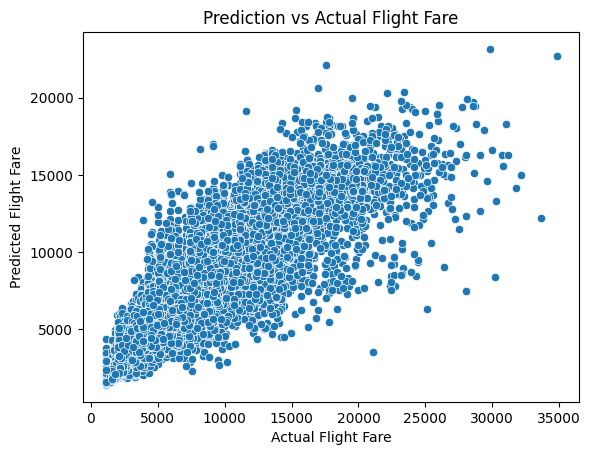

In [99]:
sns.scatterplot(x = y_test, y = y_pred_test)
plt.xlabel('Actual Flight Fare')
plt.ylabel('Predicted Flight Fare')
plt.title('Prediction vs Actual Flight Fare')

- On average, youther predictions miss the true fare by about ₹1,701 (same units as price). RMSE penalizes big misses more than small ones, so it’s a strict metric.

- R² = 0.7921 (79.21%) the  model explains ~79% of the variance in prices. Formally
- The baseline predictor is a single constant (18256.741). That model can’t adapt to route, days_left, duration, etc.

- With R² = 0.7921, the model’s SSE is only ~21% of the baseline. In plain terms: compared to “always predict 18256.741”, Random Forest cuts error dramatically.

- The lower RMSE (1701 vs. “baseline RMSE”) reflects this. (Baseline RMSE equals the std. dev. of prices around 18256.741; RMSE is far smaller, hence the strong R².)